In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
#read csv
df=pd.read_csv('.\StorageInventory_2021_Q1.csv',parse_dates=['timestamp'],dtype={'temperatura': object,'water_level_dmm':object,'water_volume_lts':object,'temp5':object,'temp4':object,'temp2':object})

In [3]:
#make a original copy of df
original_df=df.copy()

In [43]:
#set timestamp as index
df = df.set_index('timestamp')
print('Dataset shape: {}'.format(df.shape))
df.head()

Dataset shape: (10148505, 28)


,Unnamed: 0,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,...,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:46,0,47936,430,964,17143.942,25.0,N1,67,357,9217.0,...,36,V61005a1b2e477d,4,1.0,Transportation,50191.0,0.0,Product 1,0.001,NaN
2021-01-01 00:00:24,1,1906999,477,1014,16200.700,26.1,N1,67,304,15727.0,...,100,V60603bQ74df1d3,4,6.0,Service Station,21259.0,1.0,Formula Diesel,0.001,NaN
2021-01-01 00:00:31,2,1907000,477,1013,11265.097,25.7,N1,66,297,11579.0,...,100,V60603bQ74df1d3,4,6.0,Service Station,15032.0,1.0,VP Diesel,0.001,0.0
2021-01-01 00:00:38,3,1907001,477,1010,865.650,24.8,N1,66,302,1865.0,...,100,V60603bQ74df1d3,4,6.0,Service Station,15032.0,1.0,VP Nafta,0.001,0.0
2021-01-01 00:00:41,4,1907002,477,1011,1929.495,26.0,N1,61,272,3255.0,...,100,V60603bQ74df1d3,4,6.0,Service Station,15032.0,1.0,Super,0.001,NaN


#Análisis de valores faltantes

##Análisis de tipo de variable luego de la importación
1) evaluar porque no se pudieron cargar temperatura y tempX como float. Lo mismo para water_level. Pasarlos a flot/int. A NaN los errores.

In [12]:
df['temperatura']=pd.to_numeric(df.temperatura,errors='coerce')
df['temp5']=pd.to_numeric(df.temp5,errors='coerce')
df['temp4']=pd.to_numeric(df.temp4,errors='coerce')
df['temp2']=pd.to_numeric(df.temp2,errors='coerce')
df['water_level_dmm']=pd.to_numeric(df.water_level_dmm,errors='coerce')
df['water_volume_lts']=pd.to_numeric(df.water_volume_lts,errors='coerce')

##Análisis de cantidad de información
1) tenemos id_tanques con pocas muestras. Que criterio de eliminación tomamos? habría que analizar como es temporalmente la muestra? y ver si X tomas sirven o no? Inicialmente tenemos 47 id_tanques con menos de 30 muestras. 

In [47]:
s=df.id_tanque.value_counts()
(s<30).sum()

47

##Evaluación de nans

<AxesSubplot:>

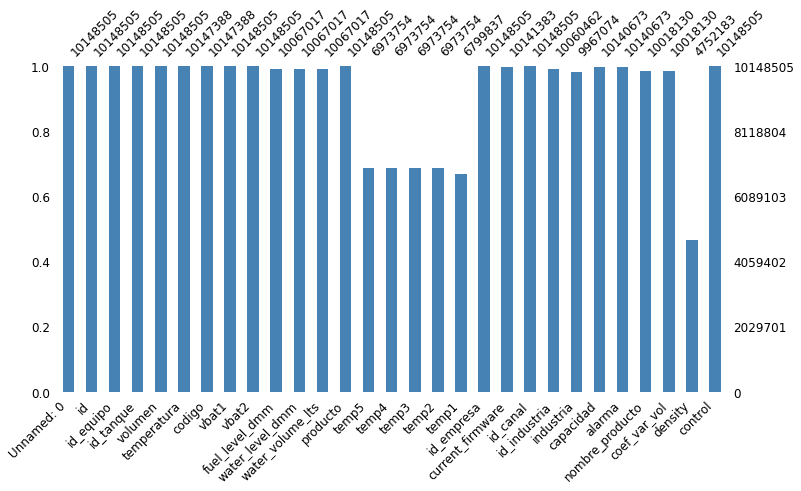

In [24]:
#búsqueda de NaN
import missingno as msno
msno.bar(df,figsize=(12, 6), fontsize=12, color='steelblue')

In [13]:
df.isna().sum()

Unnamed: 0                0
id                        0
id_equipo                 0
id_tanque                 0
volumen                   0
temperatura            1120
codigo                 1117
vbat1                     0
vbat2                     0
fuel_level_dmm        81488
water_level_dmm       81489
water_volume_lts      81489
producto                  0
temp5               3174768
temp4               3174768
temp3               3174751
temp2               3174752
temp1               3348668
id_empresa                0
current_firmware       7122
id_canal                  0
id_industria          88043
industria            181431
capacidad              7832
alarma                 7832
nombre_producto      130375
coef_var_vol         130375
density             5396322
dtype: int64

1) Cuando Temperatura y Codigo son nan, se entiende que el sensor no está funcionando (?). Se confirma que todos los casos estos, además no tienen datos de fuel_level_dmm. Descartaría estas muestras. Tengo casos con Volumen, Entonces: como se calcula el volumen?

In [ ]:
#análisis de intersección nan entre variables
df[df['temperatura'].isna()&df['codigo'].isna()&~df['fuel_level_dmm'].isna()]

2) fuel_level_dmm, water_level_dmm, water_volumen_lts tienen la misma cantidad de nan. Realizando una análisis de crosstab para casos de este tipo se observa relación con códigos L0 y L1 que indica llenado. Como se detecta? que significa L1 "error en llenado?". Otros casos tiene F1 "no se encuentra la tabla de calibración". Es la tabla para calcular el volumen?

In [22]:
df['control']=np.where(df['fuel_level_dmm'].isna()&df['water_level_dmm'].isna(),1,0)

In [23]:
pd.crosstab(df.control,df.codigo)

codigo,01,F0,F1,F2,F9,I0,I1,I2,L0,L1,...,V2,V3,V4,V5,V6,V7,V8,V9,m0,m1
control,,,,,,,,,,,,,,,,,,,,,
0,0,16896,1849779,18711,2,3873,158768,14041,20,1587061,...,340410,95,106,95,103,124,129,43,1530,463
1,1,5,2677,0,0,0,0,0,3905,4474,...,1,0,1,1,2,0,0,0,0,0


3) id_industria e industria se puede completar hacia un crossover. 
4) capacidad se utiliza para el cálculo del volumen? tenemos casos con capacidad en NaN y no hay casos con Volumen en NaN (se completa con 0?) tenemos pocos casos con volumen 0 y capacidad NaN. Podemos ver de completar capacidad con crossover usando id_tanque donde ya se haya completado. Requiere verificación, es decir que el id_tanque tenga un dato de volumen único.
5) nombre_producto y coef_var_vol, se podría verificar la posibilidad de crossover ya que en producto no tenemos NaN. Tengo muchos con producto == 0, es un producto o falta de dato? tengo más nombre_producto que producto, entonces como se relacionan?

In [47]:
df.producto.value_counts()

0    4605653
1    3948304
2     942261
3     607097
4      45190
Name: producto, dtype: int64

##Outliers
1) análisis de la variable volumen. 
a) Tiene valores negativos, no tiene lógica. Es un solo valor. Lo eliminaría. Verificación: df[df.volumen<0]
2) análisis de la variable temperatura
cuál es el rango que soportan las sondas que estamos utilizando? cuál es la temperatura mínima que podría medir, por ejemplo, hay casos de congelación del producto? 
cuál es la tempratura máxima que podría medir?
Tengo muchos datos por encima de la temp de ebullicion de nafta y diesel. Es corrrecto? como usamos esta información?
3) análisis de variable capacidad
Habría que evaluar cada tanque y confirmar que tengan un valor de capacidad correcto. Es decir, distinto de 0, si son distintos (para mismo tanque) con poca variación entre datos. Buscamos esta información a continuación. La std donde tenemos datos, son muy pequeñas. Podríamos decir que los datos cargados son válidos. 

In [52]:
aux=df.groupby(['id_tanque'])['capacidad'].describe()
aux[aux['std']!=0]

,count,mean,std,min,25%,50%,75%,max
id_tanque,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
949,15585.0,40000.1,1.176560e-08,40000.1,40000.1,40000.1,40000.1,40000.1
101307,7720.0,30000.1,3.929272e-09,30000.1,30000.1,30000.1,30000.1,30000.1
101516,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101661,19637.0,50000.1,1.617487e-08,50000.1,50000.1,50000.1,50000.1,50000.1
101775,21426.0,6136.8,2.085520e-09,6136.8,6136.8,6136.8,6136.8,6136.8
102627,1.0,1258.0,NaN,1258.0,1258.0,1258.0,1258.0,1258.0
102703,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102772,1.0,20000.0,NaN,20000.0,20000.0,20000.0,20000.0,20000.0


#Análisis de uniformidad de la toma (uniformidad en el tiempo)

Análisis por id_tanque. Se busca diferencia de horas entre timestamps consecutivos

In [80]:
#se arma un array con los id_tanque
tanques_unique=df.id_tanque.unique()

In [49]:
#CODIGO INCOMPLETO - la idea es buscar para cada id_tanque y haciendo un resample - que tiempo usar? - y buscar los false donde no hay dato
for id in tanques_unique:
    missing = df[df['id_tanque']==id].resample('1min').min().notnull() 